<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/01_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Обучение модели с разными гиперпараметрами, функциями активации и оптимизаторами**




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchsummary import summary

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Загрузка MNIST dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.13),(0.3))]
)

train_dataset = torchvision.datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root='data',
    train=False,
    transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 892873.49it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 129635.37it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1060551.84it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3906198.23it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Создаю функцию для экспериментов с разными batch_size и learning_rate
def experiment_for_model(model, batch_size, learning_rate, num_epochs=2):
  # Data loader
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=True
  )

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False
  )

  # Перенос модели
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  loss_function = nn.CrossEntropyLoss()

  # Обучение модели
  loss_list = [] # значения функции потерь на каждом шаге обучения
  total_step = len(train_dataloader) # количество батчей в одной эпохе

  for epoch in range(1, num_epochs + 1):
    for i, (images, labels) in enumerate(train_dataloader):

      # перенос тензоров на выбранное устройство
      images = images.to(device)
      labels = labels.to(device)

      # прямой проход
      outputs = model(images) # предсказания модели для текущего батча изображений
      loss = loss_function(outputs, labels) # вычисление функции потерь между предсказаниями и истинными метками

      optimizer.zero_grad() # обнуление градиентов
      loss.backward()       # вычисление градиентов
      nn.utils.clip_grad_norm_(model.parameters(), 2)
      optimizer.step()      # обновление параметров модели

      loss_list.append(loss.detach().cpu().numpy())
      # if i % 100 == 0:
      #   print(f'Эпоха [{epoch}/{num_epochs}], Шаг [{i+1}/{total_step}], Loss: {loss.item():.4f}')

  # Тестирование модели
  # отключение вычисления градиентов
  with torch.no_grad():
    correct = 0 # счетчик подсчета количества правильных предсказаний модели
    total = 0 # счетчик для подсчета общего количества протестированных изображений

    for images, labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images) # прямой проход
      _, predicted = torch.max(outputs.data, 1) # находит индекс максимального значения вдоль измерения 1
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  #print(f'Accuracy на тестовых изображениях: {accuracy:.2f}')

  return accuracy, loss_list

# 1. Обучение линейной модели на датасете MNIST, использовав разные значения для learning rate и batch_size

In [ ]:
# Создание класса линейной модели
class FCNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(x.size(0), -1) #то же самое x = x.view(-1, 28*28)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
%%time
# Создание модели
lin_model = FCNet()

# Эксперименты с разными batch_size и learning_rate
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.1, 1.0]

lin_results = []

for batch_size in batch_sizes:
  for lr in learning_rates:
    #print(f'\nТестирование batch_size={batch_size}, learning_rate={lr}')
    lin_accuracy, loss_list = experiment_for_model(lin_model, batch_size, lr)
    lin_results.append((batch_size, lr, lin_accuracy))

# Вывод
print('\nРезультаты экспериментов:')
lin_result_df = pd.DataFrame(lin_results, columns=['Batch Size', 'Learning Rate', 'Accuracy test(%)'])
print(lin_result_df)

print('\nЛучший результат:')
lin_best_result = lin_result_df.loc[lin_result_df['Accuracy test(%)'].idxmax()]
print(lin_best_result)
# print(f"{'Batch Size':<12} {'Learning Rate':<15} {'Accuracy test(%)':<10}")
# for batch_size, lr, accuracy in results:
#   print(f'{batch_size:<12} {lr:<15} {accuracy:<10.2f}')


Результаты экспериментов:
    Batch Size  Learning Rate  Accuracy test(%)
0           16          0.001             89.63
1           16          0.010             94.77
2           16          0.100             96.54
3           16          1.000             71.46
4           32          0.001             71.71
5           32          0.010             73.94
6           32          0.100             86.13
7           32          1.000             75.70
8           64          0.001             75.84
9           64          0.010             76.78
10          64          0.100             87.54
11          64          1.000             89.29
12         128          0.001             89.25
13         128          0.010             89.38
14         128          0.100             90.83
15         128          1.000             91.25

Лучший результат:
Batch Size          16.00
Learning Rate        0.10
Accuracy test(%)    96.54
Name: 2, dtype: float64
CPU times: user 8min 7s, sys: 4.28 s

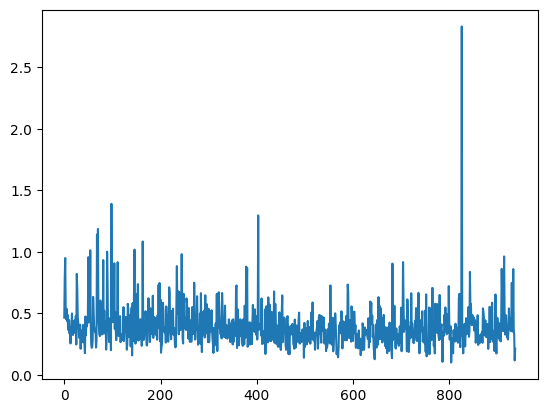

In [ ]:
# Визуализация
plt.plot(loss_list)

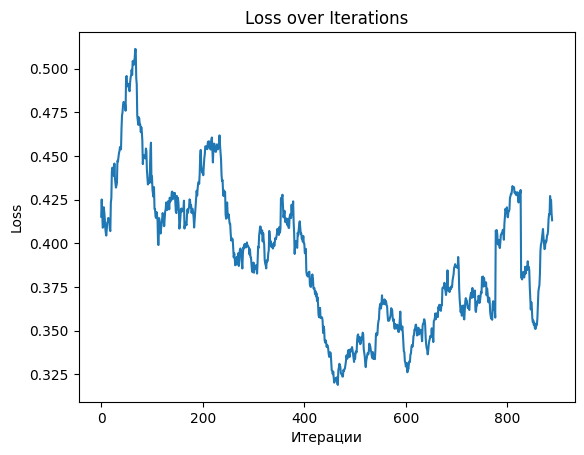

In [ ]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

lin_loss_plot = moving_average(loss_list, window_size=50)
plt.plot(lin_loss_plot)
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

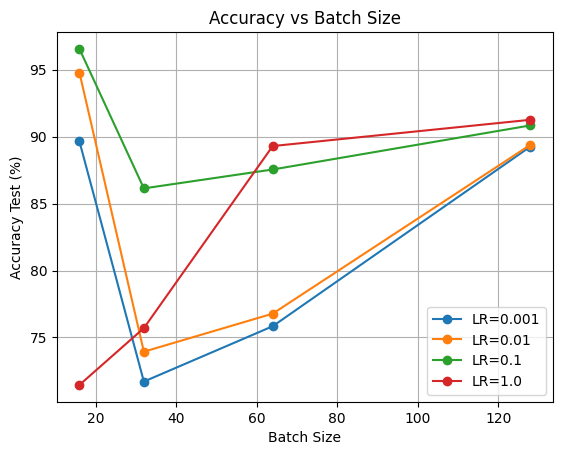

In [ ]:
# График зависимости точности от размера батча для каждого Learning_rate
for lr in learning_rates:
  subset = lin_result_df[lin_result_df['Learning Rate'] == lr]
  plt.plot(subset['Batch Size'], subset['Accuracy test(%)'], marker='o', label=f'LR={lr}')

plt.xlabel('Batch Size')
plt.ylabel('Accuracy Test (%)')
plt.title('Accuracy vs Batch Size')
plt.legend()
plt.grid(True)
plt.show()

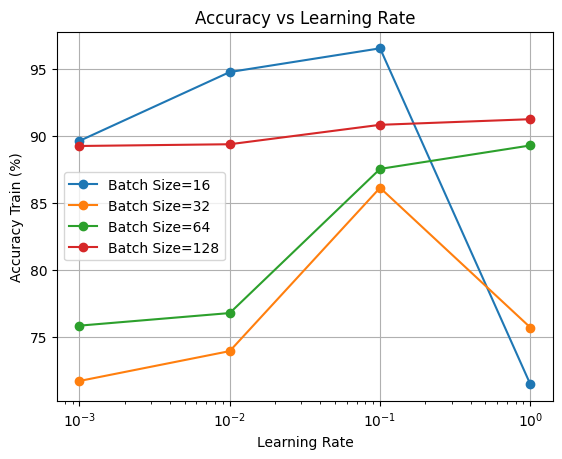

In [ ]:
# График зависимости точности от learning_rate для каждого batch_size
for batch_size in batch_sizes:
  subset = lin_result_df[lin_result_df['Batch Size'] == batch_size]
  plt.plot(subset['Learning Rate'], subset['Accuracy test(%)'], marker='o', label=f'Batch Size={batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Train (%)')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# Сохранение состояния модели
torch.save(lin_model.state_dict(), 'lin_model.ckpt')

# Загрузка сохраненного состояния
#lin_model.load_state_dict(torch.load('lin_model_bs32_lr0.001.ckpt'))
#lin_model.to(device)

# Сохранение всей модели
#torch.save(lin_model, 'lin_model.pth')

# Загрузка всей модели
#lin_model = torch.load('lin_model.pth')
#lin_model.to(device)

#2. Обучение сверточной модели на датасете MNIST, использовав разные параметры для learning rate.


In [ ]:
# Создание класса сверточной модели
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, (3, 3), padding=1)
    self.conv2 = nn.Conv2d(64, 64, (3, 3), padding=1)
    self.max_pool = nn.MaxPool2d(2, stride=2)
    self.fc = nn.Linear(in_features=64*14*14, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max_pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [ ]:
%%time
# Создание модели
svert_model = ConvNet()

# Эксперименты с разными batch_size и learning_rate
batch_size = 32
learning_rates = [0.001, 0.01, 0.1, 1.0]

svert_results = []

for lr in learning_rates:
  #print(f'\nТестирование batch_size={batch_size}, learning_rate={lr}')
  svert_accuracy, svert_loss_list = experiment_for_model(svert_model, batch_size, lr)
  svert_results.append((batch_size, lr, svert_accuracy))

# Вывод
print('\nРезультаты экспериментов:')
svert_result_df = pd.DataFrame(svert_results, columns=['Batch Size', 'Learning Rate', 'Accuracy test(%)'])
print(svert_result_df)

print('\nЛучший результат:')
svert_best_result = svert_result_df.loc[svert_result_df['Accuracy test(%)'].idxmax()]
print(svert_best_result)


Результаты экспериментов:
   Batch Size  Learning Rate  Accuracy test(%)
0          32          0.001             91.03
1          32          0.010             97.36
2          32          0.100             98.54
3          32          1.000             95.66

Лучший результат:
Batch Size          32.00
Learning Rate        0.10
Accuracy test(%)    98.54
Name: 2, dtype: float64
CPU times: user 2min 29s, sys: 1.19 s, total: 2min 30s
Wall time: 2min 34s


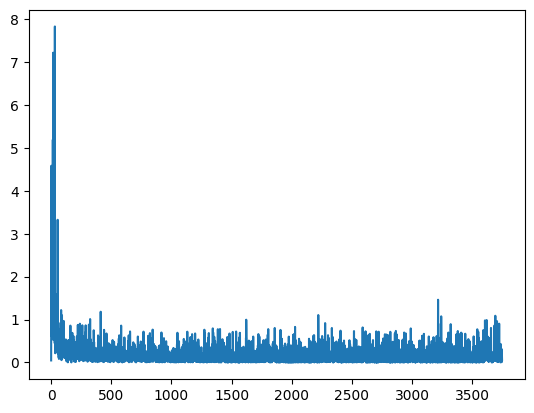

In [ ]:
# Визуализация
plt.plot(svert_loss_list)

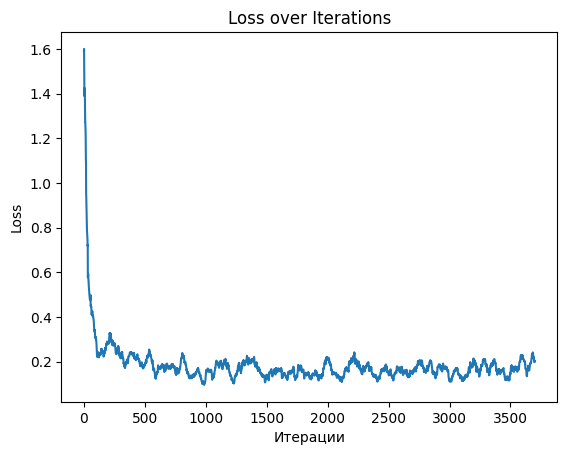

In [ ]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

svert_loss_plot = moving_average(svert_loss_list, window_size=50)
plt.plot(svert_loss_plot)
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

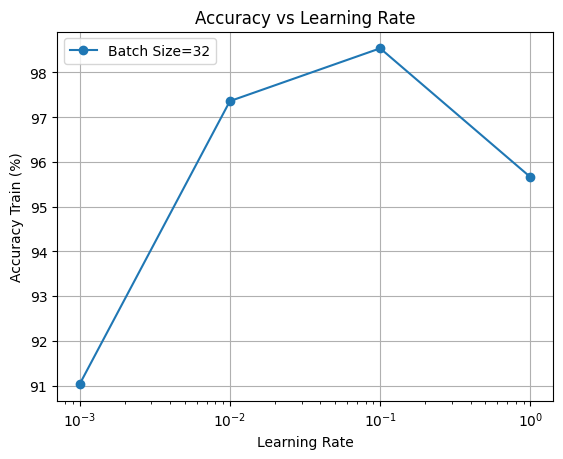

In [ ]:
# График зависимости точности от learning_rate для каждого batch_size
subset = svert_result_df[svert_result_df['Batch Size'] == batch_size]
plt.plot(subset['Learning Rate'], subset['Accuracy test(%)'], marker='o', label=f'Batch Size={batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Train (%)')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# Сохранение состояния модели
torch.save(svert_model.state_dict(), 'svert_model.ckpt')

# 3. Обучение модели, изменив архитектуру модели, добавив или убрав слои. Можно изменить архитектуру, изменив кол-во нейронов/каналов для каждого слоя.


In [ ]:
# Создание класса измененной сверточной модели
class ConvNet_change(nn.Module):
  def __init__(self):
    super().__init__()
    # Первый сверточный блок
    self.conv1 = nn.Conv2d(1, 32, (3, 3), padding=1) # уменьшаю количество фильтров до 32 # 28 x 28 x 1 -> 28 x 28 x 32
    self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=1) # 28 x 28 x 32 -> 28 x 28 x 64
    # Второй сверточный блок
    self.conv3 = nn.Conv2d(64, 128, (3, 3), padding=1) # добавляю третий сверточный слой с 128 фильтрами # 28 x 28 x 64 -> 28 x 28 x 128
    # Слой пуллинга
    self.max_pool = nn.MaxPool2d(2, stride=2) # 28 x 28 x 128 -> 14 x 14 x 128
    # Полносвязный слой с dropout для регуляризации
    self.fc1 = nn.Linear(in_features=128*14*14, out_features=256) # или 128 или 512 нейронов
    self.fc2 = nn.Linear(in_features=256, out_features=10) # 10 - количество классов (цифр в датасете)
    self.dropout = nn.Dropout(0.5) # вероятность отключения случайных нейронов для борьбы с переобчением

  def forward(self, x):
    # Первый сверточный блок
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    # Второй сверточный блок
    x = F.relu(self.conv3(x))
    x = self.max_pool(x)
    # Выпрямление тензора
    x = x.view(x.size(0), -1) # чтобы передать данные в полносвязные слои
    # Полносвязные слои с dropout
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [ ]:
%%time
# Создание модели
svert_model_change = ConvNet_change()

batch_size = 32
learning_rates = [0.001, 0.01, 0.1]

svert_change_results = []


for lr in learning_rates:
  svert_model_change = ConvNet_change()
  svert_change_accuracy, svert_change_loss_list = experiment_for_model(svert_model_change, batch_size, lr)
  svert_change_results.append((batch_size, lr, svert_change_accuracy))

# Вывод
print('\nРезультаты экспериментов с новой архитектурой:')
svert_change_result_df = pd.DataFrame(svert_change_results, columns=['Batch Size', 'Learning Rate', 'Accuracy test(%)'])
print(svert_change_result_df)

print('\nЛучший результат с новой архитектурой:')
svert_change_best_result = svert_change_result_df.loc[svert_change_result_df['Accuracy test(%)'].idxmax()]
print(svert_change_best_result)


Результаты экспериментов с новой архитектурой:
   Batch Size  Learning Rate  Accuracy test(%)
0          32          0.001             86.43
1          32          0.010             93.80
2          32          0.100             97.81

Лучший результат с новой архитектурой:
Batch Size          32.00
Learning Rate        0.10
Accuracy test(%)    97.81
Name: 2, dtype: float64
CPU times: user 2min 18s, sys: 958 ms, total: 2min 19s
Wall time: 2min 20s


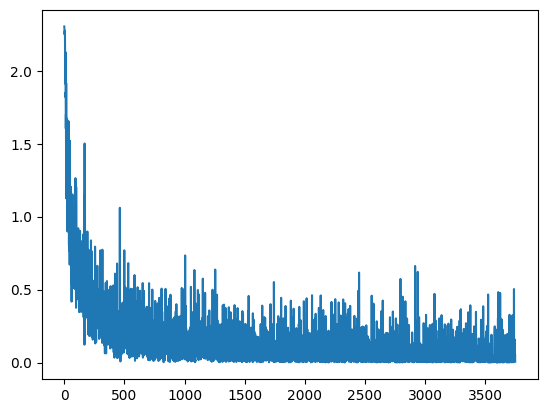

In [ ]:
# Визуализация
plt.plot(svert_change_loss_list)

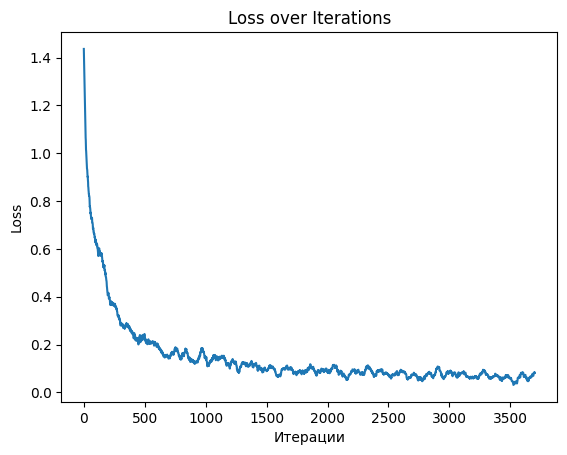

In [ ]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

svert_change_loss_plot = moving_average(svert_change_loss_list, window_size=50)
plt.plot(svert_change_loss_plot)
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

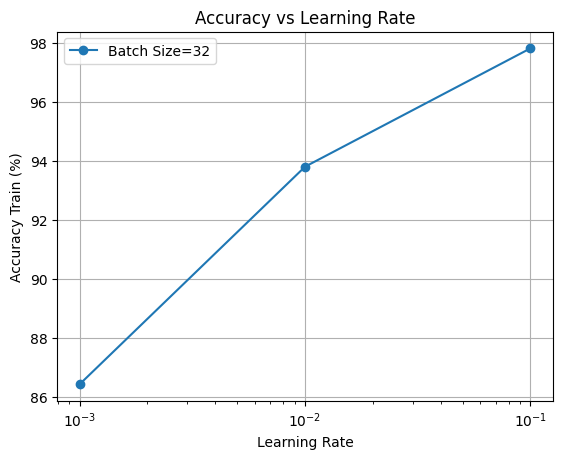

In [ ]:
# График зависимости точности от learning_rate для каждого batch_size
subset = svert_change_result_df[svert_change_result_df['Batch Size'] == batch_size]
plt.plot(subset['Learning Rate'], subset['Accuracy test(%)'], marker='o', label=f'Batch Size={batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Train (%)')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# Сохранение состояния модели
torch.save(svert_model_change.state_dict(), 'svert_model_change.ckpt')

#4. Обучение модели, изменяя функции активации между слоями.


In [ ]:
# Создание класса измененной сверточной модели
class ConvNetChangeLeakyReLU(nn.Module):
  def __init__(self):
    super().__init__()
    # Первый сверточный блок
    self.conv1 = nn.Conv2d(1, 32, (3, 3), padding=1) # уменьшаю количество фильтров до 32 # 28 x 28 x 1 -> 28 x 28 x 32
    self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=1) # 28 x 28 x 32 -> 28 x 28 x 64
    # Второй сверточный блок
    self.conv3 = nn.Conv2d(64, 128, (3, 3), padding=1) # добавляю третий сверточный слой с 128 фильтрами # 28 x 28 x 64 -> 28 x 28 x 128
    # Слой пуллинга
    self.max_pool = nn.MaxPool2d(2, stride=2) # 28 x 28 x 128 -> 14 x 14 x 128
    # Полносвязный слой с dropout для регуляризации
    self.fc1 = nn.Linear(in_features=128*14*14, out_features=256) # или 128 или 512 нейронов
    self.fc2 = nn.Linear(in_features=256, out_features=10) # 10 - количество классов (цифр в датасете)
    self.dropout = nn.Dropout(0.5) # вероятность отключения случайных нейронов для борьбы с переобчением
    # Leaky LeLU с параметром отрицательного наклона
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

  def forward(self, x):
    # Первый сверточный блок
    x = self.leaky_relu(self.conv1(x))
    x = self.leaky_relu(self.conv2(x))
    # Второй сверточный блок
    x = self.leaky_relu(self.conv3(x))
    x = self.max_pool(x)
    # Выпрямление тензора
    x = x.view(x.size(0), -1) # чтобы передать данные в полносвязные слои
    # Полносвязные слои с dropout
    x = self.leaky_relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [ ]:
%%time
# Создание модели
svert_model_leaky_relu = ConvNetChangeLeakyReLU()

batch_sizes = 32
learning_rates = [0.001, 0.01, 0.1]

results_leaky_relu = []

for lr in learning_rates:
  svert_model_leaky_relu = ConvNetChangeLeakyReLU()
  leaky_relu_accuracy, leaky_relu_loss_list = experiment_for_model(svert_model_leaky_relu, batch_size, lr)
  results_leaky_relu.append((batch_size, lr, leaky_relu_accuracy))

# Вывод
print('\nРезультаты экспериментов с Leaky LeLU:')
results_leaky_relu_df = pd.DataFrame(results_leaky_relu, columns=['Batch Size', 'Learning Rate', 'Accuracy test(%)'])
print(results_leaky_relu_df)

print('\nЛучший результат с Leaky LeLU:')
leaky_relu_best_result = results_leaky_relu_df.loc[results_leaky_relu_df['Accuracy test(%)'].idxmax()]
print(leaky_relu_best_result)


Результаты экспериментов с Leaky LeLU:
   Batch Size  Learning Rate  Accuracy test(%)
0          32          0.001             86.94
1          32          0.010             93.55
2          32          0.100             98.08

Лучший результат с Leaky LeLU:
Batch Size          32.00
Learning Rate        0.10
Accuracy test(%)    98.08
Name: 2, dtype: float64
CPU times: user 2min 17s, sys: 966 ms, total: 2min 18s
Wall time: 2min 19s


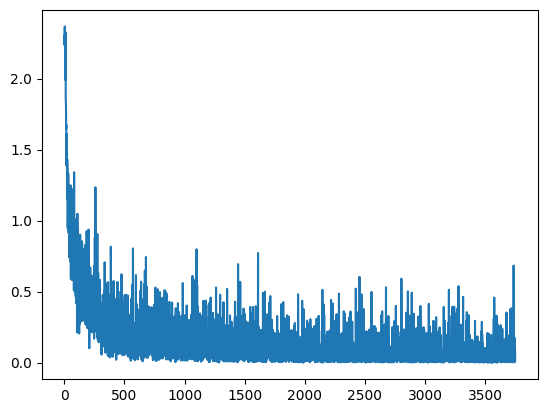

In [ ]:
# Визуализация
plt.plot(leaky_relu_loss_list)

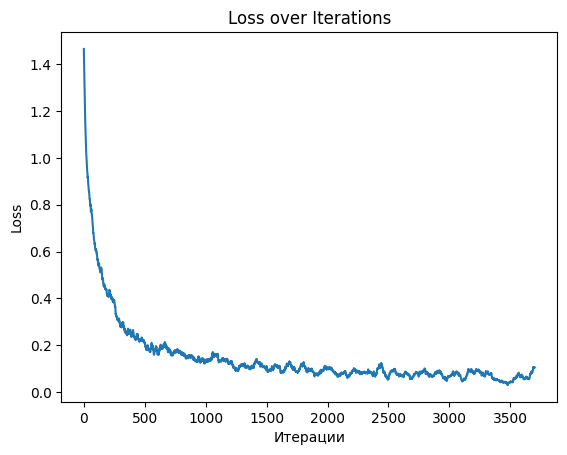

In [ ]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

leaky_relu_loss_plot = moving_average(leaky_relu_loss_list, window_size=50)
plt.plot(leaky_relu_loss_plot)
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

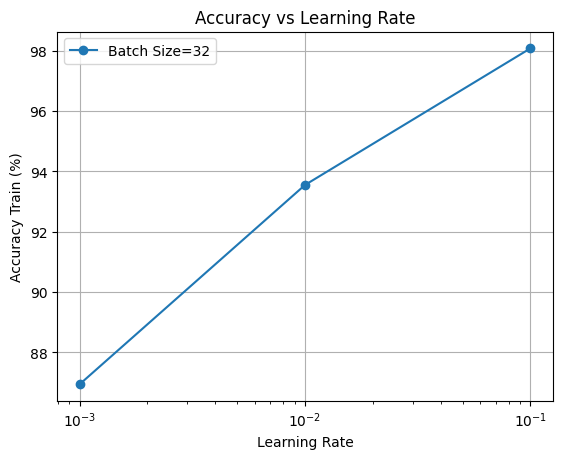

In [ ]:
# График зависимости точности от learning_rate для каждого batch_size

subset = results_leaky_relu_df[results_leaky_relu_df['Batch Size'] == batch_size]
plt.plot(subset['Learning Rate'], subset['Accuracy test(%)'], marker='o', label=f'Batch Size={batch_size}')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Train (%)')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
# Сохранение состояния модели
torch.save(svert_model_leaky_relu.state_dict(), 'svert_model_leaky_relu.ckpt')

# Сравнительный анализ


In [ ]:
loss_dicts = {'Линейная модель': loss_list,
              'Сверточная модель': svert_loss_list,
              'Сверточная модель с измененной архитектурой': svert_change_loss_list,
              'Сверточная модель с Leaky LeLU':leaky_relu_loss_list}

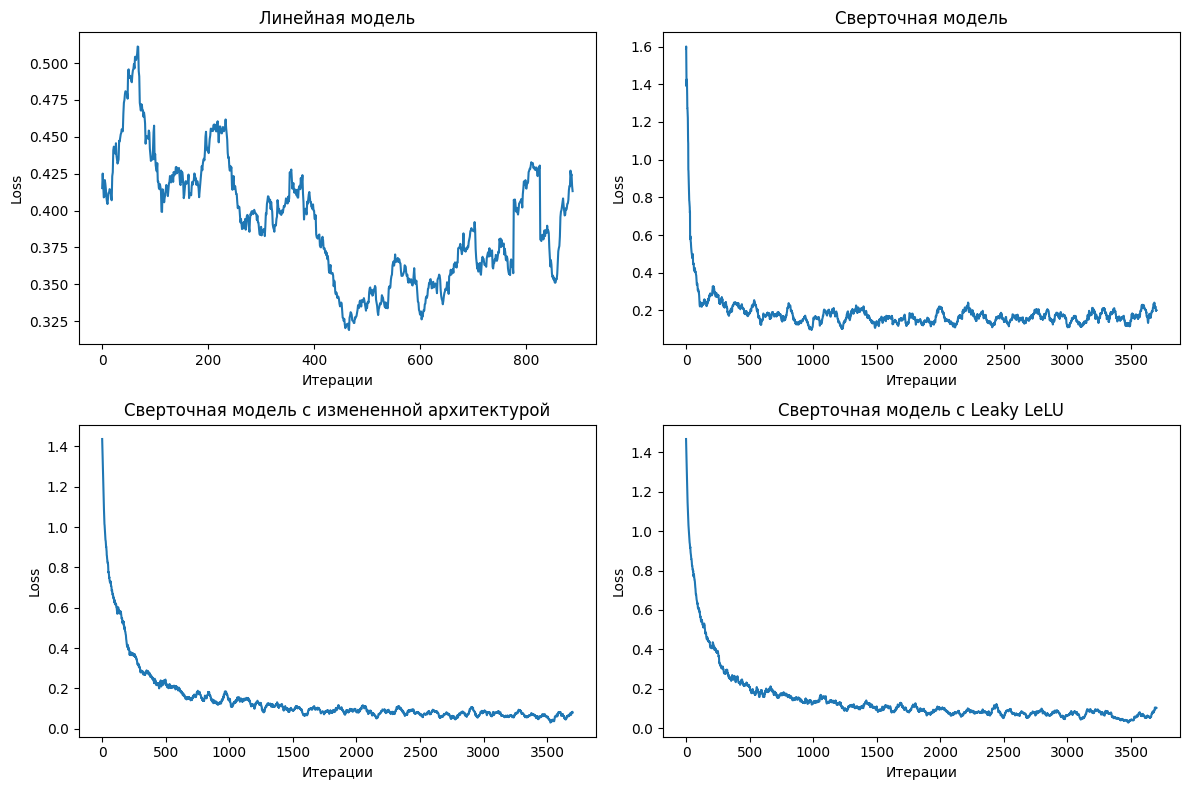

In [ ]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (name, dict_list) in enumerate(loss_dicts.items()):
  lin_loss_plot = moving_average(dict_list, window_size=50)
  axs[i // 2, i % 2].plot(lin_loss_plot)
  axs[i // 2, i % 2].set_title(name)
  axs[i // 2, i % 2].set_xlabel('Итерации')
  axs[i // 2, i % 2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

Вывод:

Линейная модель не учится, происходит взрыв градиентов. Несмотря на нормализацию перед обучением и обрезку градиентов с помощью torch.nn.utils.clip_grad_norm_.

Сверточная модель выглядит тоже недостаточно ровной, но уже вырисовывается функция потерь, которая снижается с увеличением итераций.